# Nutritional Inequality and Food Prices  

## Introduction  

Nutritional inequality refers to disparities in diet quality and access to healthy food across different socioeconomic groups. Rising food prices, food deserts, and lack of nutrition education contribute to this issue, affecting millions of Americans. As of 2025, **around 40 million Americans** experience food insecurity, with many turning to cheaper, less nutritious options due to affordability and accessibility challenges.  

In this project, we explore **how food prices impact dietary choices and accessibility across different regions and income levels**. Our research focuses on:  

- **Comparing** the cost of nutrient-dense foods (fruits, vegetables) versus processed foods  
- **Analyzing** geographical disparities in food availability (food deserts)  
- **Investigating** the role of socioeconomic factors in nutritional choices  
- **Assessing** the impact of nutrition education on food access and consumption  

To address these questions, we leverage publicly available datasets from **USDA, BLS, FAO, and Kaggle**, integrating statistical analysis and visualization techniques. Our goal is to uncover meaningful insights into the systemic causes of nutritional inequality and potential policy interventions.  

---  
### Notebook Workflow  
🔹 **Data Wrangling:** Cleaning and preprocessing datasets  
🔹 **Combining Data:** Merging multiple sources for comprehensive analysis  
🔹 **Statistical Analysis:** Identifying correlations between food prices, income, and access  
🔹 **Visualization:** Presenting trends and disparities through charts and maps  

This notebook serves as a prototype for our analysis, demonstrating key data transformations, exploratory statistics, and preliminary findings. 🚀  

In [23]:
# Load in packages

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# others

In [24]:
# Load in datasets
folder_path = 'project data/'

historical_changes_consumer_price = pd.read_csv(folder_path + '(historical) changes_consumer_price.csv')
historical_producer_price_changes = pd.read_csv(folder_path + '(historical) producer_price_changes.csv')
consumer_price = pd.read_csv(folder_path + 'changes_consumer_price_indices.csv')
producer_price = pd.read_csv(folder_path + 'changes_producer_price.csv')
food_access_data = pd.read_excel(folder_path + 'FoodAccessResearchAtlasData2019.xlsx')

## Data Wrangling 

In [25]:
# cleaning historical producer price changes 

historical_producer_price_changes['Year'] = pd.to_numeric(historical_producer_price_changes['Year'], errors='coerce')
historical_producer_price_changes['Percent change'] = pd.to_numeric(historical_producer_price_changes['Percent change'], errors='coerce')
historical_producer_price_changes = historical_producer_price_changes.dropna()

def categorize_food(item):
    item = item.lower()
    if "farm-level" in item:
        return "Farm Level"
    elif "wholesale" in item:
        return "Wholesale"
    elif "processed" in item:
        return "Processed"
    elif "unprocessed" in item:
        return "Unprocessed"
    elif "finished" in item:
        return "Finished"
    else:
        return "Other"

# create new category 
historical_producer_price_changes['Category'] = historical_producer_price_changes['Producer Price Index item'].apply(categorize_food)

In [26]:
## Combining Data 



## Visualization

Producer Data Summary:
               Producer Price Index item  Year  Percent change   Category
0  Unprocessed foodstuffs and feedstuffs  1974             5.2  Processed
1  Unprocessed foodstuffs and feedstuffs  1975             1.3  Processed
2  Unprocessed foodstuffs and feedstuffs  1976            -0.8  Processed
3  Unprocessed foodstuffs and feedstuffs  1977             0.9  Processed
4  Unprocessed foodstuffs and feedstuffs  1978            12.6  Processed


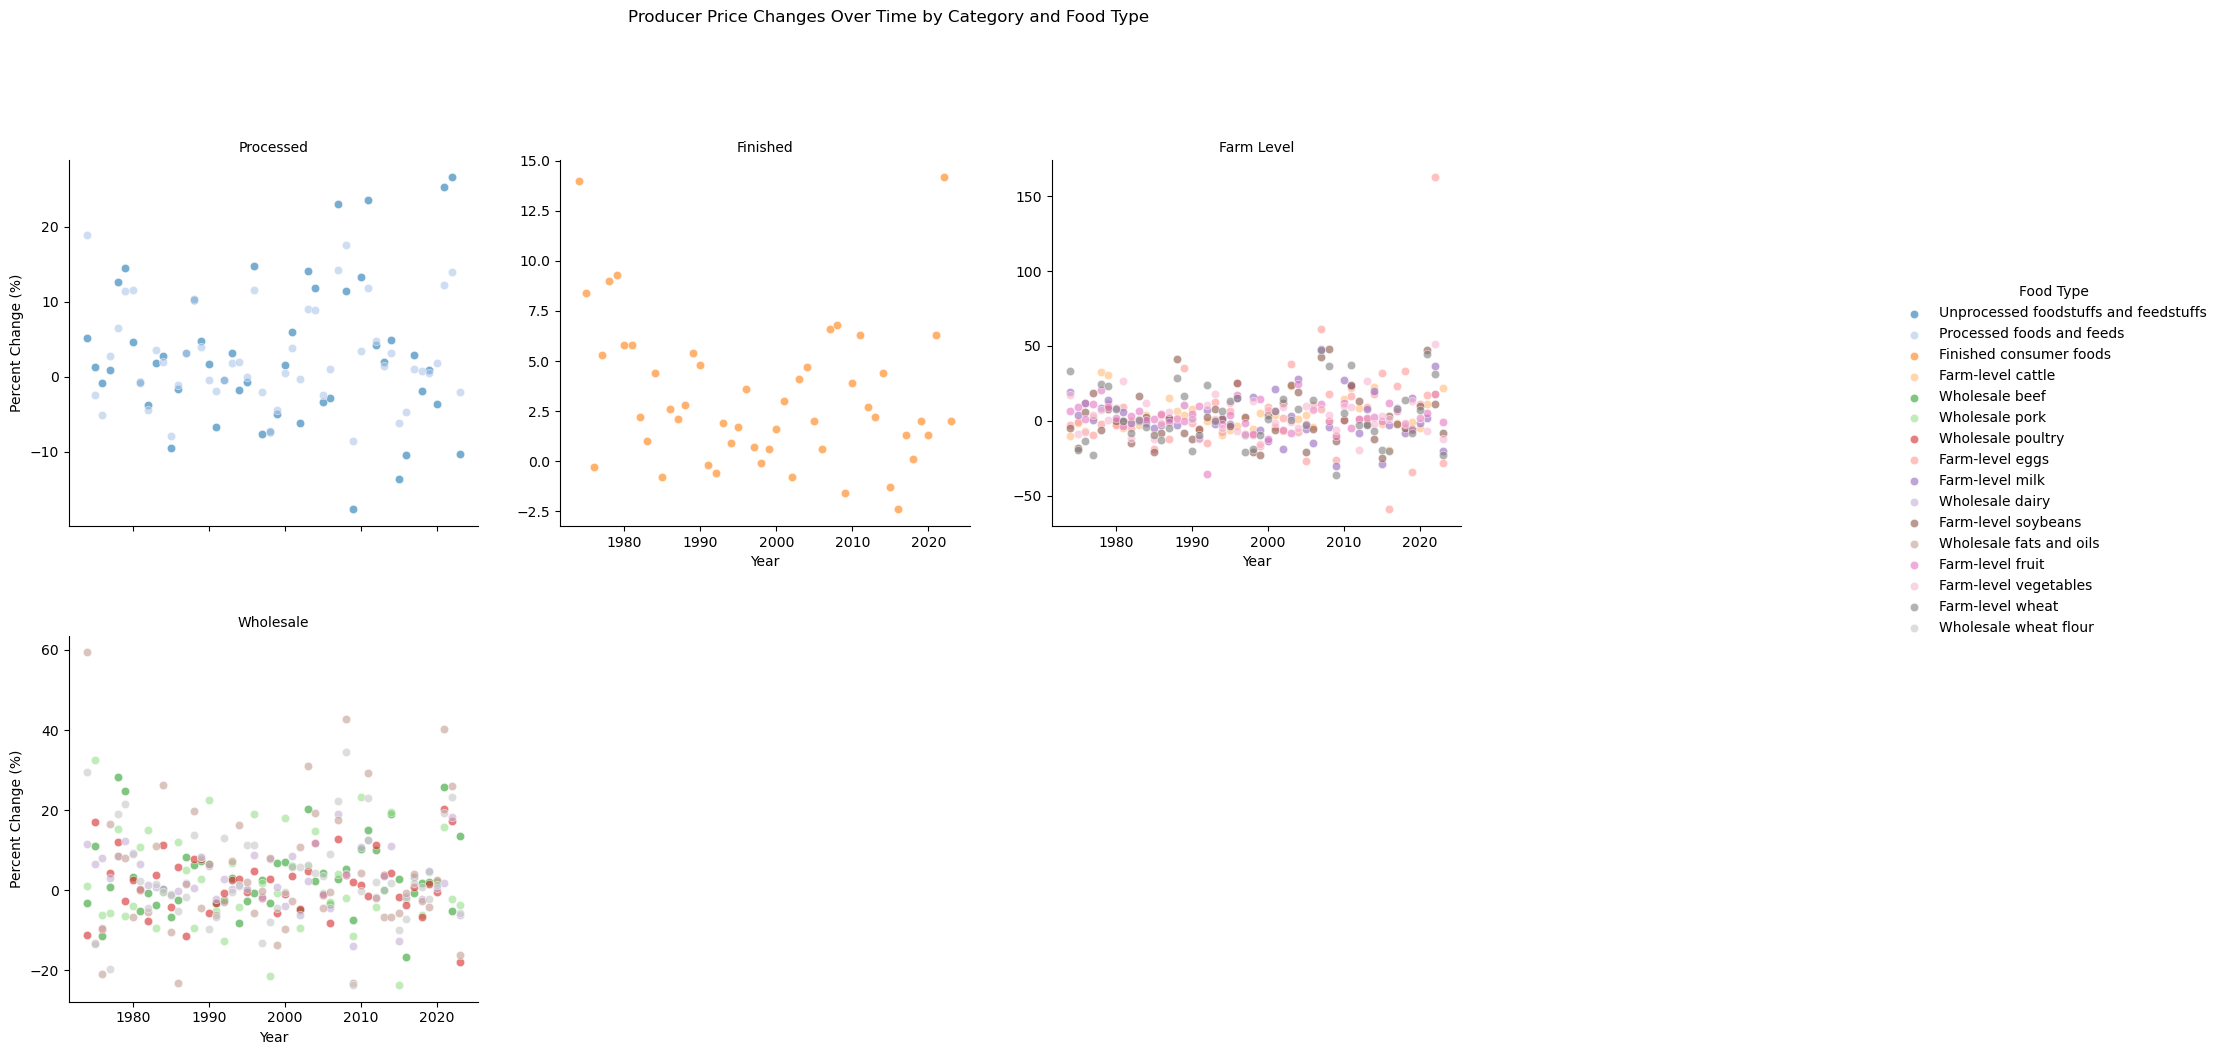

In [27]:
print("Producer Data Summary:")
print(historical_producer_price_changes.head())

# scatterplot faceted 
g = sns.FacetGrid(
    historical_producer_price_changes,
    col="Category",
    col_wrap=3,
    height=5,
    sharey=False,
    hue="Producer Price Index item",
    palette="tab20",
)

# scatter + line 
g.map_dataframe(
    sns.scatterplot,
    x="Year",
    y="Percent change",
    alpha=0.6,  
)

# legend + title 
g.add_legend(title="Food Type", bbox_to_anchor=(1.05, 0.6), loc='center left')
g.set_titles("{col_name}")
g.set_axis_labels("Year", "Percent Change (%)")
g.fig.suptitle("Producer Price Changes Over Time by Category and Food Type", y=1.05)

# layout 
plt.subplots_adjust(top=0.9, hspace=0.3, wspace=0.2)
plt.show()